# 합성곱신경망 - 다중분류
- 가위바위보 3개 이미지 분류 

In [1]:
import urllib.request
import zipfile

### 데이터 다운 받기

In [2]:
# wget 패키지 설치 
# Anaconda Prompt에서 
# deepEnv 가상환경에서 설치 
# pip install wget 

# webget 명령어 : 인터넷에서 파일을 다운로드 받기 위한 명령 유틸리티 


In [21]:
import wget

In [4]:
url = "https://storage.googleapis.com/learning-datasets/rps.zip"
# wget.download(url)

In [5]:
url = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
# wget.download(url)

In [6]:
# rps.zip과 rps-test-set.zip 파일 다운로드 되었는지 확인

In [32]:
import zipfile
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

- 데이터 압축 풀기

In [8]:
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
# zip_ref.extractall('./')
# zip_ref.close()

# 압축 해제되었는지 확인 

- 학습데이터 전처리및 데이터 증강을 위한 객체 생성
    - 증강을 사용하므로 전처리객체는 학습/평가 데이터 각각 생성

In [23]:
TRAINING_DIR = "./rps/"
training_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.5,
        zoom_range=[0.8,2.0],
        horizontal_flip =True,
        vertical_flip=True,
        fill_mode='nearest'
)

### 검증데이터 준비 및 전처리

### 폴더내의 이미지 파일을 폴더로 split 해주는 패키지
- Anaconda Prompt의 deepEnv에서 설치  
- pip install split-folders 
- pip install split-folders[full] 
    - progress bar를 보고 싶을때

In [10]:
# 압축 해제 
local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('./')
# zip_ref.close()

# horse-or-human 폴더 내에는 training과 validation 폴더로 나뉘어 있음
# paper, rock, scissors 3개 폴더 들어 있음

# train/val/test 나누기

- ratio 파라미터에 원하는 (train, validation, test) 비율을 입력 ex) (0.8, 0.1, 0.1)
    - splitfolders.ratio("input_folder", output="output", seed=1337, ratio=(.8, .1, .1))
    
- train/val 나누기 : train을 val로 val을 test로 사용
    - test는 제외하고 train, validation만 나누고 싶다면 두 개의 인자만 입력 ex) (0.8, 0.1)

In [12]:
# anaconda prompt의 deepEnv에서 설치
# pip install split-folders[full]

In [24]:
import splitfolders

In [25]:
# 현재 rps-test-set 폴더만 있는 상태에서
# 검증용/테스트용으로 분리

test_set_dir = './rps-test-set'
test_val_dir = './rps-test-val'

splitfolders.ratio(test_set_dir, output=test_val_dir, seed=1337, ratio=(0.8, 0.2))

# 확인
# rps-test-set폴더만 있었는데
# 이 폴더를 분리해서
# rps-test-val폴더 생성됨
# 372개 -> 297 : 75

Copying files: 372 files [00:00, 1658.97 files/s]


### 이미지 전처리

In [26]:
# 검증/테스트용 데이터는 증강하지 않고
# 학습용 데이터만 증강해도 무방함

VALIDATION_DIR = './rps-test-val/train'
TEST_DIR = './rps-test-val/val'

In [27]:
val_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [29]:
# 학습용
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(100, 100),
    class_mode='categorical' # 다중 클래스 분류
)

# 검증용
validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (100, 100),
    class_mode='categorical' # 다중 클래스 분류
)

# 테스트용
test_generator = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (100, 100),
    class_mode='categorical' # 다중 클래스 분류
)

Found 2520 images belonging to 3 classes.
Found 297 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


## 모델 생성

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling

# 모델 생성
model = Sequential()

model.add(Conv2D(16, (3,3), input_shape=(100, 100, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

# 컴파일 
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.001), 
              metrics=['accuracy'])

# 학습
model.fit(train_generator,
         epochs=15,
         validation_data=validation_generator)

Epoch 1/15
79/79 [==============================] - 20s 243ms/step - loss: 0.6368 - accuracy: 0.3599 - val_loss: 0.5584 - val_accuracy: 0.6835
Epoch 2/15
79/79 [==============================] - 19s 239ms/step - loss: 0.5409 - accuracy: 0.5643 - val_loss: 0.3729 - val_accuracy: 0.7912
Epoch 3/15
79/79 [==============================] - 21s 258ms/step - loss: 0.4121 - accuracy: 0.7357 - val_loss: 0.1797 - val_accuracy: 0.8956
Epoch 4/15
79/79 [==============================] - 20s 254ms/step - loss: 0.2854 - accuracy: 0.8115 - val_loss: 0.3611 - val_accuracy: 0.7609
Epoch 5/15
79/79 [==============================] - 25s 312ms/step - loss: 0.2152 - accuracy: 0.8687 - val_loss: 0.1393 - val_accuracy: 0.9226
Epoch 6/15
79/79 [==============================] - 20s 255ms/step - loss: 0.1462 - accuracy: 0.9202 - val_loss: 0.0640 - val_accuracy: 0.9562
Epoch 7/15
79/79 [==============================] - 21s 264ms/step - loss: 0.1493 - accuracy: 0.9226 - val_loss: 0.0972 - val_accuracy: 0.9293

In [36]:
# 테스트 데이터 검증
model.evaluate(test_generator)

3/3 [==============================] - 0s 67ms/step - loss: 0.0553 - accuracy: 0.9600


[0.05534183606505394, 0.9599999785423279]

In [39]:
# Early-stopping, check point 설정
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

check_pointer = ModelCheckpoint('rps_best_model.keras')
early_stopping_callback = EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_generator,
                  epochs=15,
                   validation_data=(validation_generator),
                   callbacks=[check_pointer, early_stopping_callback]
                  )

Epoch 1/15
79/79 [==============================] - 18s 225ms/step - loss: 0.0482 - accuracy: 0.9738 - val_loss: 0.0878 - val_accuracy: 0.9259
Epoch 2/15
79/79 [==============================] - 17s 220ms/step - loss: 0.0562 - accuracy: 0.9762 - val_loss: 0.0633 - val_accuracy: 0.9663
Epoch 3/15
79/79 [==============================] - 18s 226ms/step - loss: 0.0455 - accuracy: 0.9754 - val_loss: 0.1070 - val_accuracy: 0.9259
Epoch 4/15
79/79 [==============================] - 18s 233ms/step - loss: 0.0380 - accuracy: 0.9794 - val_loss: 0.0643 - val_accuracy: 0.9596


In [45]:
model.evaluate(test_generator)

3/3 [==============================] - 0s 61ms/step - loss: 0.0492 - accuracy: 0.9600


[0.04919149726629257, 0.9599999785423279]

#### 조기종료, 체크포인트 추가

- 예측 확인

In [43]:
import sys

sample_images = ['./image/rsp_image_{}.jpg'.format(i) for i in range(1, 4)]
sample_images.append('./image/rsp_image_4.png')
sample_images

['./image/rsp_image_1.jpg',
 './image/rsp_image_2.jpg',
 './image/rsp_image_3.jpg',
 './image/rsp_image_4.png']

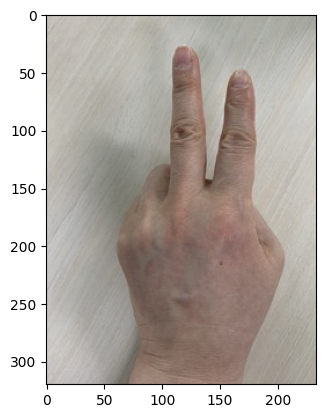

1/1 [==============================] - 0s 20ms/step
[[1. 0. 0.]]
./image/rsp_image_1.jpg는 보 입니다.
-------------------


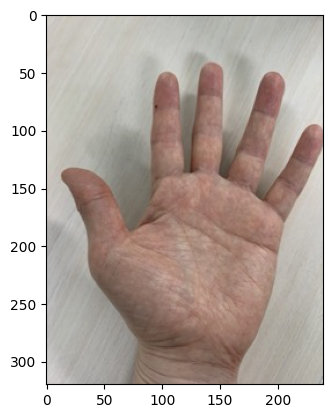

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0.]]
./image/rsp_image_2.jpg는 보 입니다.
-------------------


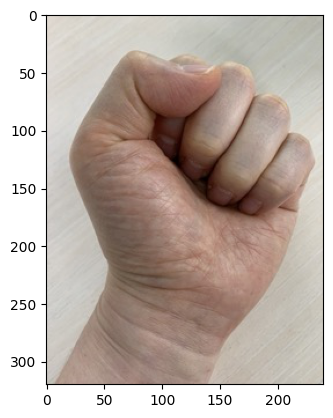

1/1 [==============================] - 0s 19ms/step
[[1. 0. 0.]]
./image/rsp_image_3.jpg는 보 입니다.
-------------------


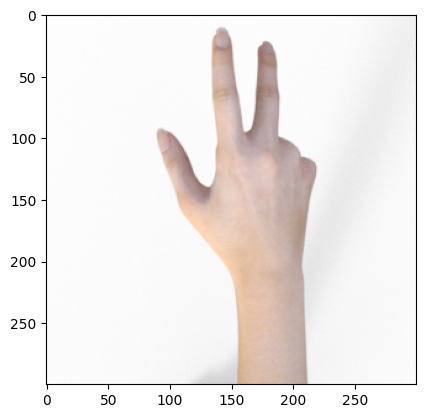

1/1 [==============================] - 0s 20ms/step
[[1. 0. 0.]]
./image/rsp_image_4.png는 보 입니다.
-------------------


In [44]:
# 잘 예측하는지 확인 
rsp_name = ['보', '바위', '가위']

for n in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(n))
    plt.show()
    
    # 이미지 처리
    img = tf.keras.utils.load_img(n, target_size=(100, 100))
    x = tf.keras.utils.img_to_array(img)
    x = np.expand_dims(x, axis=0)  # (1, 100, 100, 3)
    
    # 클래스 예측
    classes = model.predict(x)
    print(classes)
    idx = np.argmax(classes[0])
    
    print(n + '는 {} 입니다.'.format(rsp_name[idx]))
  
    print('-------------------')


### np.expand_dims 함수
- numpy 패키지에서 제공하는 함수로, 배열의 차원을 확장
- 주로 딥러닝에서 다차원 배열을 다룰 때 사용되며, 특히 텐서의 차원을 조정할 때 자주 활용됨
- 문법
    - np.expand_dims(arr, axis)
        - arr: 차원을 확장할 배열
        - axis: 새로 추가될 차원의 위치. 이 값은 정수 또는 튜플 형태로 지정할 수 있음. 기본값은 0이며, 이는 첫 번째 차원(인덱스 0) 앞에 새로운 차원을 추가하겠다는 의미임

## 드롭아웃 규제
- 과대적합 방지
- 신경망층에서 dropout 추가 : drop 아웃층은 어디든 상관없음
- Improving neural networks by preventing co-adaptation of feature 논문에 따르면 dropout이 많은 모델일 수록 loss 증가를 막는 연구가 있음
    - 단 dropout은 너무 많으면 속도가 급격히 느려짐  
        - 그러므로 많은 차이가 없으면 밀집신경망층 1개 정도에 추가하는 것이 일반적임

In [ ]:
## model2 

In [ ]:
# Flatten() 다음에 Dropout(0.5) 레이어 추가
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling

# 모델 생성
model2 = Sequential()

model2.add(Conv2D(16, (3,3), input_shape=(100, 100, 3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(32, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64, (3,3), activation='relu'))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(3, activation='softmax'))



In [ ]:
# 컴파일

# 체크포인트, early-stopping

# 학습 : history



In [ ]:
# 평가 : evaluate

In [ ]:
# 테스트 이미지로 확인 

### dropout으로 단순화 결과

- 실제 이미지로 테스트 했을때로 성능이 떨어짐
    - dropout 규제는 효과가 없다

In [ ]:
import tensorflow as tf
# import tensorflow_datasets as tfds
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

## 모델 재구성 : model3


### padding(패딩)
- 출력 크기를 보장하기 위해 입력 데이터의 사면에 특정값으로 채우는 것
- 일반적으로 0으로 채움 
- 종류 : 
    - valid padding
        - 디폴트
        - 출력 크기가 입력 크기보다 작음
    - same padding
        - 입력 크기와 출력 크기를 동일하게 유지

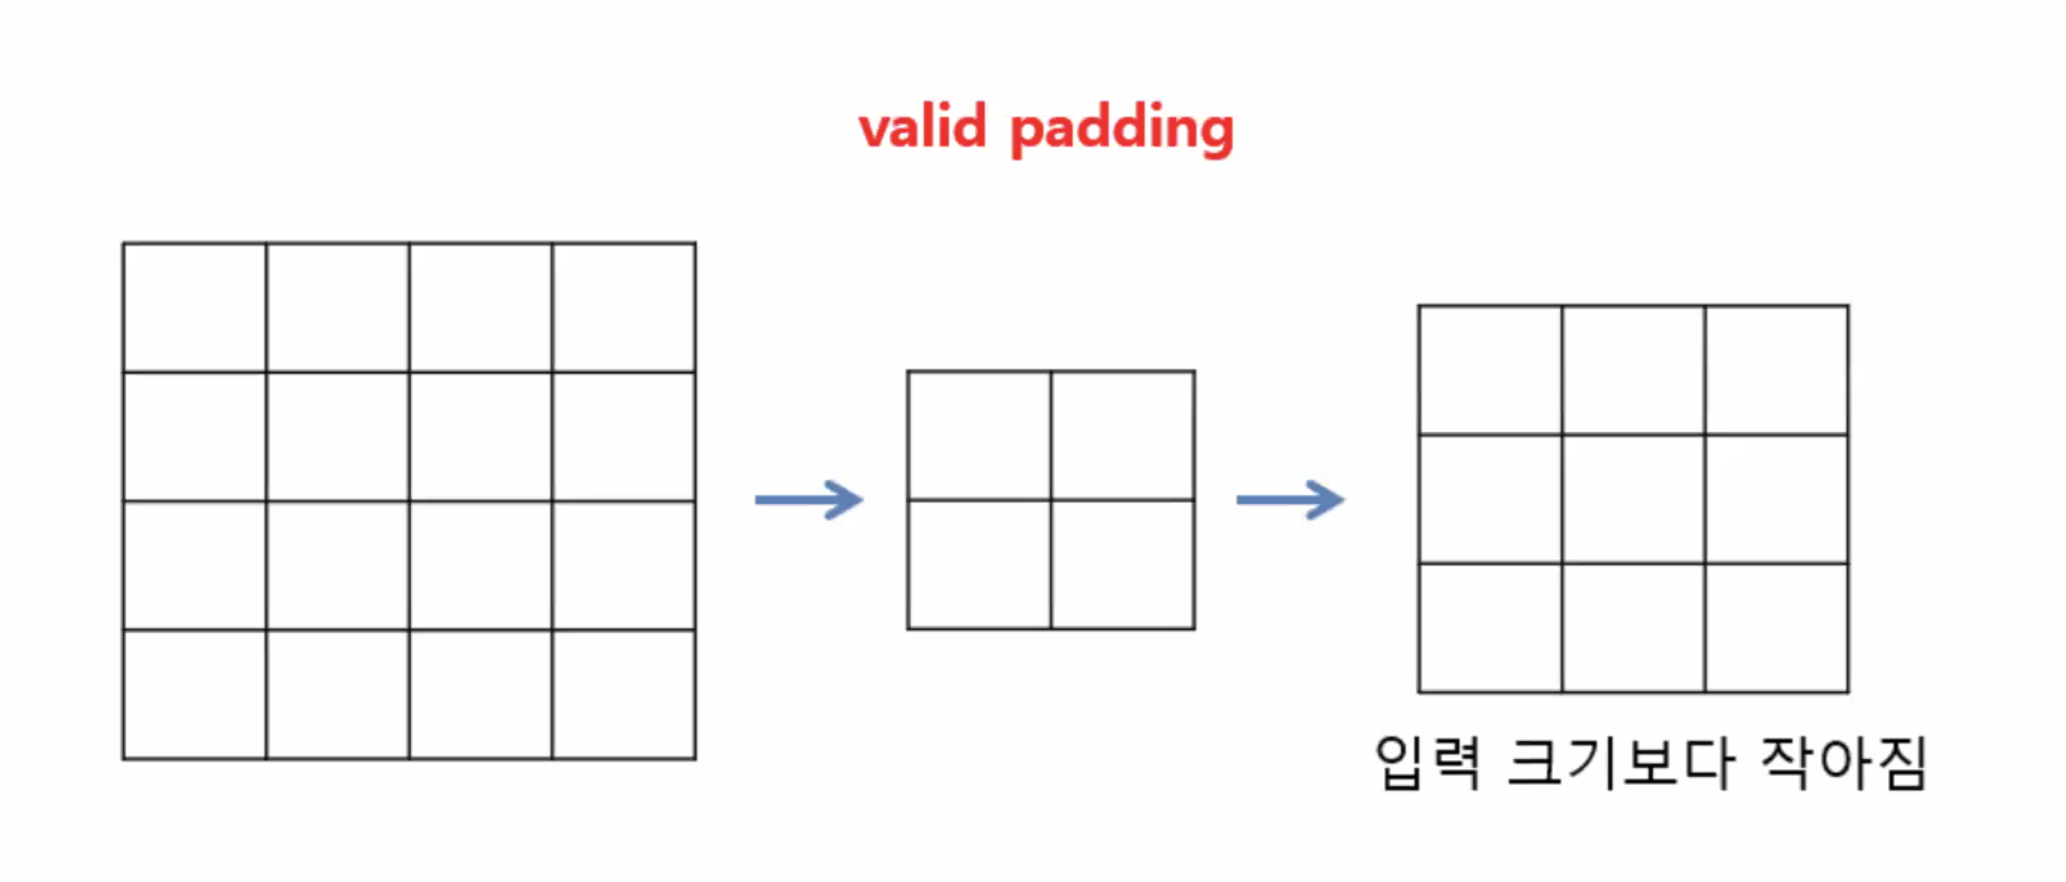

In [46]:
# padding='same' 로 설정 
# 모든 Conv2D(...., padding='same')

# 모델 생성

# 컴파일

# 체크포인트 & EarlyStopping

# 학습

In [ ]:
# 평가

In [ ]:
# 테스트 이미지로